Source - http://nbviewer.jupyter.org/url/legacydirs.umiacs.umd.edu/~hcorrada/PML/src/prac2_finished.ipynb

# An example for classifier evaluation

In [1]:
import pandas as pd
import numpy as np
import pylab as pl

### The data

We are using data from police department of the City of Chicago for the last year obtained here: https://data.cityofchicago.org/Public-Safety/Crimes-One-year-prior-to-present/x2n5-8w5q. I want
to know if knowing the location and date of the week of the event, one can predict if an arrest will be made. Here is a plot
of the data:

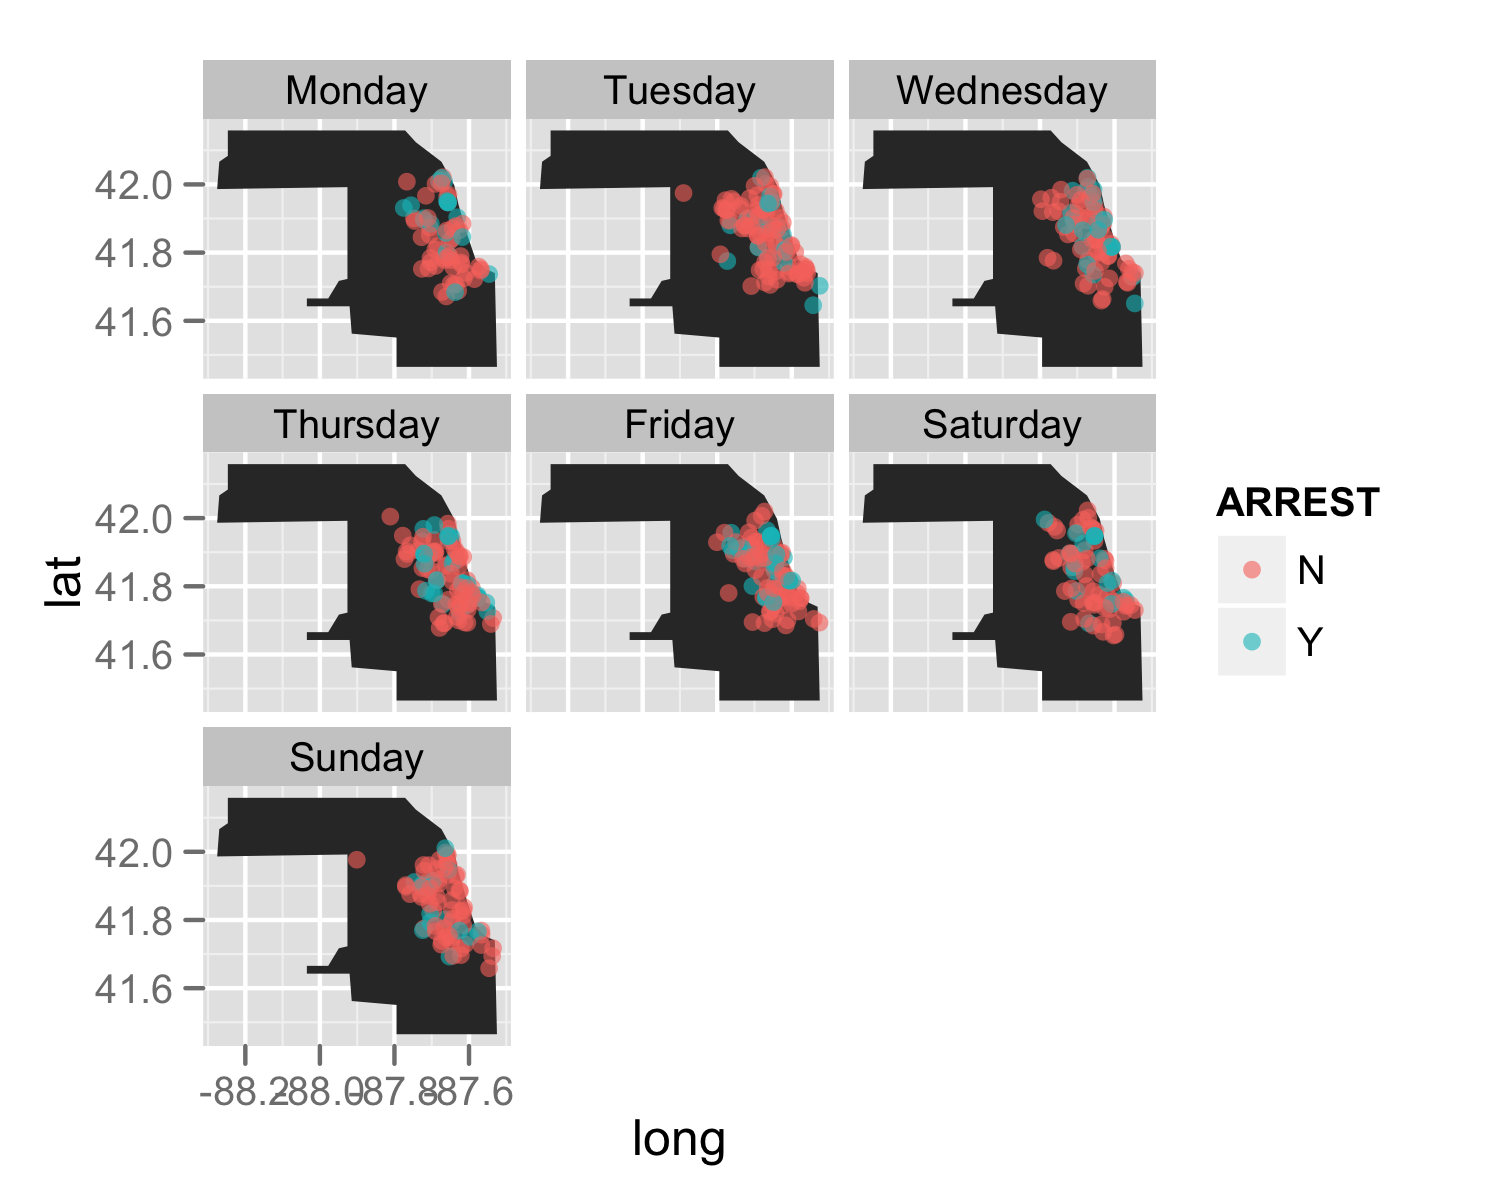

In [2]:
from IPython.core.display import Image
Image(filename='chicago.png') 


Full disclosure: this plot was made using [R](http://r-project.org), not python.

In [6]:
crime_data = pd.read_csv('Crimes_-_One_year_prior_to_present.zip')

In [7]:
print crime_data.columns
print crime_data.shape

Index([u'CASE#', u'DATE  OF OCCURRENCE', u'BLOCK', u' IUCR',
       u' PRIMARY DESCRIPTION', u' SECONDARY DESCRIPTION',
       u' LOCATION DESCRIPTION', u'ARREST', u'DOMESTIC', u'BEAT', u'WARD',
       u'FBI CD', u'X COORDINATE', u'Y COORDINATE', u'LATITUDE', u'LONGITUDE',
       u'LOCATION'],
      dtype='object')
(254675, 17)


In [5]:
crime_data.ix[:5,:8]

CASE#     DATE  OF OCCURRENCE                  BLOCK  IUCR  \
0  HX411573  09/01/2014 07:35:00 PM    032XX S ASHLAND AVE  1120   
1  HX411608  09/01/2014 07:35:00 PM  102XX S WENTWORTH AVE  143A   
2  HX411622  09/01/2014 07:40:00 PM   008XX N MICHIGAN AVE  0860   
3  HX411571  09/01/2014 07:45:00 PM        015XX E 55TH ST  0860   
4  HX411662  09/01/2014 07:46:00 PM      010XX N AVERS AVE  2027   
5  HX411590  09/01/2014 07:50:00 PM    011XX W BELMONT AVE  0460   

   PRIMARY DESCRIPTION     SECONDARY DESCRIPTION  LOCATION DESCRIPTION ARREST  
0   DECEPTIVE PRACTICE                   FORGERY                STREET      Y  
1    WEAPONS VIOLATION  UNLAWFUL POSS OF HANDGUN                STREET      Y  
2                THEFT              RETAIL THEFT      DEPARTMENT STORE      N  
3                THEFT              RETAIL THEFT    GROCERY FOOD STORE      Y  
4            NARCOTICS               POSS: CRACK             RESIDENCE      Y  
5              BATTERY                    SIMPLE                 OTHER      N

In [7]:
crime_data.ix[:5,[1,7,14,15]]

DATE  OF OCCURRENCE ARREST   LATITUDE  LONGITUDE
0  09/01/2014 07:35:00 PM      Y        NaN        NaN
1  09/01/2014 07:35:00 PM      Y  41.707739 -87.628186
2  09/01/2014 07:40:00 PM      N  41.897765 -87.623958
3  09/01/2014 07:45:00 PM      Y  41.795302 -87.588201
4  09/01/2014 07:46:00 PM      Y  41.899735 -87.722698
5  09/01/2014 07:50:00 PM      N  41.939743 -87.658021

In [13]:
import time
day=[time.strftime('%a', time.strptime(x, '%m/%d/%Y %H:%M:%S %p')) for x in crime_data.ix[:,1].tolist()]

In [34]:
crime_data_proc=crime_data.ix[:,[7,14,15]]
#crime_data_proc.assign(DAY=day)
crime_data_proc['DAY']=day
crime_data_proc.ix[:5,:]

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


ARREST   LATITUDE  LONGITUDE  DAY
0      Y        NaN        NaN  Mon
1      Y  41.707739 -87.628186  Mon
2      N  41.897765 -87.623958  Mon
3      Y  41.795302 -87.588201  Mon
4      Y  41.899735 -87.722698  Mon
5      N  41.939743 -87.658021  Mon

In [35]:
np.random.seed(1)
nsamples = crime_data_proc.shape[0]
allindices = np.arange(nsamples)
np.random.shuffle(allindices)
ntest_samples = int(np.floor(.2 * nsamples))

test_indices = allindices[:ntest_samples]
train_indices = allindices[ntest_samples:]

crime_train = crime_data_proc.ix[train_indices,:]
crime_test = crime_data_proc.ix[test_indices,:]


crime_train.to_pickle('crime_train.pkl')
crime_test.to_pickle('crime_test.pkl')

### The classifiers

I'm going to look at two classifiers: a silly one-node decision tree (based on the day of the week the event took place in), 
and a K-NN classifier.

In [36]:
crime_train.head()

ARREST   LATITUDE  LONGITUDE  DAY
211521      N  41.761253 -87.613951  Tue
86700       N  41.751070 -87.598970  Mon
104805      N  41.803445 -87.744266  Tue
65988       N  41.913741 -87.732408  Sat
156912      N  41.906406 -87.679793  Fri

In [37]:
crime_train.groupby('DAY').size()

DAY
Fri    30563
Mon    28643
Sat    30150
Sun    28968
Thu    28064
Tue    28770
Wed    28582
dtype: int64

In [38]:
crime_train[crime_train['ARREST']=='Y'].groupby('DAY').size()

DAY
Fri    8393
Mon    7468
Sat    8095
Sun    7539
Thu    7718
Tue    7855
Wed    7771
dtype: int64

In [39]:
prop_arrests = 1.0 * crime_train[crime_train['ARREST']=='Y'].groupby('DAY').size()/crime_train.groupby('DAY').size()

In [40]:
prop_arrests

DAY
Fri    0.274613
Mon    0.260727
Sat    0.268491
Sun    0.260253
Thu    0.275014
Tue    0.273027
Wed    0.271884
dtype: float64

Here is the code defining our silly decision tree. An arrest will be made if the proportion of arrests for that day of the
week is greater than .25.

In [41]:
class SillyCrime:
    def __init__(self, traindat, cutoff=.25):
        self.prop_arrests = 1.0 * traindat[traindat['ARREST']=='Y'].groupby('DAY').size()/traindat.groupby('DAY').size()
        self.cutoff = cutoff
        
    def classify(self, testdat):
        props = self.prop_arrests[testdat['DAY']]
        return ['Y' if x >= self.cutoff else 'N' for x in props], props

sillyCrime = SillyCrime(crime_train)
sillyClass, sillyScore = sillyCrime.classify(crime_test)

We need to massage our data slightly to use it in a KNN classifier

In [42]:
crime_train2 = crime_train[['LATITUDE','LONGITUDE']]
days = [item for item, _ignore in prop_arrests.iteritems()]
for day in days:
    crime_train2[day] = [1 if x == day else 0 for x in crime_train['DAY']]
crime_train2['CLASS']=[+1 if x=='Y' else -1 for x in crime_train['ARREST']]
crime_train2.ix[:5,:]

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


LATITUDE  LONGITUDE  Fri  Mon  Sat  Sun  Thu  Tue  Wed  CLASS
211521  41.761253 -87.613951    0    0    0    0    0    1    0     -1
86700   41.751070 -87.598970    0    1    0    0    0    0    0     -1
104805  41.803445 -87.744266    0    0    0    0    0    1    0     -1
65988   41.913741 -87.732408    0    0    1    0    0    0    0     -1
156912  41.906406 -87.679793    1    0    0    0    0    0    0     -1
188907  41.904464 -87.640536    0    0    0    1    0    0    0     -1
195460  41.739181 -87.624215    0    1    0    0    0    0    0     -1
33938   41.995674 -87.721341    0    0    0    0    0    0    1     -1
219801  41.767978 -87.646915    0    0    1    0    0    0    0      1
117722  41.874590 -87.708956    0    0    0    0    0    1    0      1
20515   41.765990 -87.576444    0    0    1    0    0    0    0      1
48379   41.968091 -87.731607    0    1    0    0    0    0    0     -1
182068  41.767918 -87.645706    0    0    0    0    1    0    0     -1
3930    41.863532 -87.614814    0    0    1    0    0    0    0     -1
236911  41.803084 -87.611789    0    0    0    1    0    0    0     -1
147443  41.849121 -87.701503    1    0    0    0    0    0    0      1
82536   41.899247 -87.628427    0    1    0    0    0    0    0     -1
116476  41.883500 -87.627877    0    0    0    1    0    0    0      1
89483   41.769128 -87.587969    1    0    0    0    0    0    0     -1
211687  41.900630 -87.628313    0    0    0    0    0    1    0     -1
98626   41.879236 -87.624347    0    0    0    1    0    0    0     -1
38151   41.784878 -87.689748    0    0    0    0    0    1    0     -1
27792   41.871214 -87.653401    0    0    0    0    0    1    0      1
40757   41.768701 -87.646291    1    0    0    0    0    0    0      1
3008    41.841758 -87.623146    1    0    0    0    0    0    0     -1
160960  41.880741 -87.724598    0    0    0    0    1    0    0      1
27283   41.802789 -87.662238    0    1    0    0    0    0    0      1
226289        NaN        NaN    0    1    0    0    0    0    0     -1
108323  41.762187 -87.690518    0    0    0    1    0    0    0     -1
184142  41.926524 -87.634051    0    0    0    1    0    0    0     -1
...           ...        ...  ...  ...  ...  ...  ...  ...  ...    ...
16766   41.800732 -87.648931    0    0    0    0    0    1    0     -1
38405   41.946464 -87.735718    0    0    0    0    0    1    0     -1
50212   41.966472 -87.657996    0    0    0    0    0    0    1      1
127924  41.823666 -87.603072    0    0    1    0    0    0    0     -1
122119  41.805421 -87.725964    0    0    0    0    0    0    1     -1
67751   41.690864 -87.624578    0    1    0    0    0    0    0      1
140085  41.881173 -87.649682    0    0    0    0    0    1    0     -1
43926   41.896812 -87.626426    0    0    0    0    0    1    0     -1
14775   41.834312 -87.726873    0    0    1    0    0    0    0     -1
129985  41.991759 -87.784027    0    0    0    0    0    1    0      1
162052  41.778524 -87.677541    1    0    0    0    0    0    0     -1
186809  41.788044 -87.787757    0    0    0    0    1    0    0     -1
221408  41.800395 -87.687880    0    1    0    0    0    0    0      1
150498  41.724965 -87.682188    0    0    0    0    0    0    1     -1
155679  41.910962 -87.694560    0    0    0    0    0    0    1      1
177591  41.720911 -87.644412    0    0    1    0    0    0    0      1
224039  41.698842 -87.655652    1    0    0    0    0    0    0     -1
117634  41.756967 -87.651478    0    0    0    0    0    1    0      1
19677   41.766907 -87.575245    1    0    0    0    0    0    0     -1
214485  41.752567 -87.578448    0    0    1    0    0    0    0     -1
57809   41.901248 -87.751927    0    0    0    1    0    0    0     -1
169316  41.751840 -87.647714    0    1    0    0    0    0    0     -1
171504  41.880427 -87.750783    0    0    0    0    1    0    0     -1
237571  41.777125 -87.648361    0    1    0    0    0    0    0     -1
190824  41.752316 -87.600363    0

In [43]:
def toKnn(dat, prop_arrests):
    newdat = dat[['LATITUDE','LONGITUDE']]
    days = [item for item, _ignore in prop_arrests.iteritems()]
    for day in days:
        newdat[day] = [1 if x == day else 0 for x in dat['DAY']]
    
    newdat['CLASS']=[+1 if x=='Y' else -1 for x in dat['ARREST']]
    return newdat

crime_train_knn = toKnn(crime_train,prop_arrests)
crime_test_knn = toKnn(crime_test,prop_arrests)

crime_test_knn

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


LATITUDE  LONGITUDE  Fri  Mon  Sat  Sun  Thu  Tue  Wed  CLASS
133741  41.683547 -87.642102    0    0    0    1    0    0    0     -1
66123   41.902623 -87.719280    0    0    1    0    0    0    0     -1
155452  41.855168 -87.625553    0    0    0    0    0    0    1     -1
51208   41.872169 -87.745784    0    0    0    0    1    0    0      1
137453  41.879433 -87.745240    1    0    0    0    0    0    0     -1
227875  41.767526 -87.674284    0    0    0    0    0    0    1     -1
31235   41.772156 -87.683596    0    0    1    0    0    0    0     -1
136387  41.867124 -87.721360    0    0    0    0    0    0    1     -1
145634  41.748743 -87.592990    0    0    0    0    0    0    1     -1
24652   41.823580 -87.706091    0    0    0    0    1    0    0     -1
130886  41.849382 -87.701512    0    0    0    0    0    0    1      1
92921   41.767234 -87.616909    1    0    0    0    0    0    0     -1
215584  41.762089 -87.696632    0    0    0    1    0    0    0     -1
202328  41.746344 -87.648773    0    0    0    0    1    0    0     -1
198859  41.903320 -87.669062    0    0    1    0    0    0    0     -1
224669  41.920242 -87.687497    1    0    0    0    0    0    0      1
172680  41.775075 -87.718728    0    0    1    0    0    0    0     -1
232795  41.794828 -87.580443    0    0    0    0    0    1    0     -1
76118   41.878246 -87.764095    0    0    1    0    0    0    0      1
179813  42.001012 -87.660725    0    1    0    0    0    0    0      1
170006  41.865215 -87.657991    0    0    0    0    0    1    0      1
233770  41.745896 -87.551446    0    0    0    0    0    0    1     -1
228481  41.919012 -87.629073    0    0    0    0    1    0    0     -1
87268   41.690535 -87.621169    0    0    0    0    0    1    0      1
74941   41.718165 -87.559962    1    0    0    0    0    0    0     -1
254088  41.871066 -87.735143    0    0    0    0    0    1    0     -1
246009  41.922735 -87.674119    1    0    0    0    0    0    0     -1
82918   41.878415 -87.699867    0    0    0    0    0    1    0     -1
144362  41.757848 -87.616694    0    1    0    0    0    0    0      1
252822  41.808523 -87.672980    0    0    0    1    0    0    0      1
...           ...        ...  ...  ...  ...  ...  ...  ...  ...    ...
91486   41.974286 -87.656358    0    0    0    0    0    1    0     -1
64650   41.767953 -87.567956    0    0    0    0    0    0    1     -1
183278  41.860677 -87.705505    0    0    1    0    0    0    0      1
58249   41.929953 -87.736390    0    0    0    1    0    0    0     -1
64020   41.841276 -87.649435    0    0    0    0    0    1    0     -1
154683  41.705936 -87.650857    0    0    0    0    0    1    0     -1
178711  41.888605 -87.624434    0    0    0    1    0    0    0     -1
41193   41.866235 -87.657822    1    0    0    0    0    0    0     -1
171088  41.883500 -87.627877    0    0    0    0    1    0    0      1
247964  41.795081 -87.663400    0    1    0    0    0    0    0     -1
178798  41.886374 -87.741658    0    0    0    1    0    0    0     -1
168451  41.904348 -87.734623    0    0    0    1    0    0    0      1
113071  41.760220 -87.702508    0    1    0    0    0    0    0     -1
188181  41.842696 -87.617220    0    0    1    0    0    0    0     -1
46493   41.778593 -87.586268    1    0    0    0    0    0    0     -1
108597  41.846337 -87.654248    0    1    0    0    0    0    0     -1
132540  41.885341 -87.738711    1    0    0    0    0    0    0     -1
105171  41.764058 -87.659856    0    0    0    0    0    1    0     -1
153312  41.793359 -87.587824    0    0    0    1    0    0    0     -1
246641  41.739255 -87.585698    0    0    1    0    0    0    0      1
73189   41.873970 -87.674099    0    0    0    0    0    1    0     -1
78526   41.689221 -87.612777    0    0    0    0    0    0    1     -1
145585  41.757290 -87.646640    0    0    0    0    0    0    1     -1
248323  41.900040 -87.723783    0    1    0    0    0    0    0      1
70799   41.800517 -87.666120    1

In [44]:
crime_train_knn.ix[:5,:]

LATITUDE  LONGITUDE  Fri  Mon  Sat  Sun  Thu  Tue  Wed  CLASS
211521  41.761253 -87.613951    0    0    0    0    0    1    0     -1
86700   41.751070 -87.598970    0    1    0    0    0    0    0     -1
104805  41.803445 -87.744266    0    0    0    0    0    1    0     -1
65988   41.913741 -87.732408    0    0    1    0    0    0    0     -1
156912  41.906406 -87.679793    1    0    0    0    0    0    0     -1
188907  41.904464 -87.640536    0    0    0    1    0    0    0     -1
195460  41.739181 -87.624215    0    1    0    0    0    0    0     -1
33938   41.995674 -87.721341    0    0    0    0    0    0    1     -1
219801  41.767978 -87.646915    0    0    1    0    0    0    0      1
117722  41.874590 -87.708956    0    0    0    0    0    1    0      1
20515   41.765990 -87.576444    0    0    1    0    0    0    0      1
48379   41.968091 -87.731607    0    1    0    0    0    0    0     -1
182068  41.767918 -87.645706    0    0    0    0    1    0    0     -1
3930    41.863532 -87.614814    0    0    1    0    0    0    0     -1
236911  41.803084 -87.611789    0    0    0    1    0    0    0     -1
147443  41.849121 -87.701503    1    0    0    0    0    0    0      1
82536   41.899247 -87.628427    0    1    0    0    0    0    0     -1
116476  41.883500 -87.627877    0    0    0    1    0    0    0      1
89483   41.769128 -87.587969    1    0    0    0    0    0    0     -1
211687  41.900630 -87.628313    0    0    0    0    0    1    0     -1
98626   41.879236 -87.624347    0    0    0    1    0    0    0     -1
38151   41.784878 -87.689748    0    0    0    0    0    1    0     -1
27792   41.871214 -87.653401    0    0    0    0    0    1    0      1
40757   41.768701 -87.646291    1    0    0    0    0    0    0      1
3008    41.841758 -87.623146    1    0    0    0    0    0    0     -1
160960  41.880741 -87.724598    0    0    0    0    1    0    0      1
27283   41.802789 -87.662238    0    1    0    0    0    0    0      1
226289        NaN        NaN    0    1    0    0    0    0    0     -1
108323  41.762187 -87.690518    0    0    0    1    0    0    0     -1
184142  41.926524 -87.634051    0    0    0    1    0    0    0     -1
...           ...        ...  ...  ...  ...  ...  ...  ...  ...    ...
16766   41.800732 -87.648931    0    0    0    0    0    1    0     -1
38405   41.946464 -87.735718    0    0    0    0    0    1    0     -1
50212   41.966472 -87.657996    0    0    0    0    0    0    1      1
127924  41.823666 -87.603072    0    0    1    0    0    0    0     -1
122119  41.805421 -87.725964    0    0    0    0    0    0    1     -1
67751   41.690864 -87.624578    0    1    0    0    0    0    0      1
140085  41.881173 -87.649682    0    0    0    0    0    1    0     -1
43926   41.896812 -87.626426    0    0    0    0    0    1    0     -1
14775   41.834312 -87.726873    0    0    1    0    0    0    0     -1
129985  41.991759 -87.784027    0    0    0    0    0    1    0      1
162052  41.778524 -87.677541    1    0    0    0    0    0    0     -1
186809  41.788044 -87.787757    0    0    0    0    1    0    0     -1
221408  41.800395 -87.687880    0    1    0    0    0    0    0      1
150498  41.724965 -87.682188    0    0    0    0    0    0    1     -1
155679  41.910962 -87.694560    0    0    0    0    0    0    1      1
177591  41.720911 -87.644412    0    0    1    0    0    0    0      1
224039  41.698842 -87.655652    1    0    0    0    0    0    0     -1
117634  41.756967 -87.651478    0    0    0    0    0    1    0      1
19677   41.766907 -87.575245    1    0    0    0    0    0    0     -1
214485  41.752567 -87.578448    0    0    1    0    0    0    0     -1
57809   41.901248 -87.751927    0    0    0    1    0    0    0     -1
169316  41.751840 -87.647714    0    1    0    0    0    0    0     -1
171504  41.880427 -87.750783    0    0    0    0    1    0    0     -1
237571  41.777125 -87.648361    0    1    0    0    0    0    0     -1
190824  41.752316 -87.600363    0

<pre><code>
def classify(self, testdat, k=None):
        """
        Classify a set of samples

        Arguments:
          testdat: pandas.DataFrame
          k: None, integer, or integer list of ascending k values

        Returns:
          matrix of (+1/-1) labels (if k is a list)
          list of labels, if k is integer

        """
        testdat = testdat.values
        ntest_samples = testdat.shape[0]

        if k is None:
            k = self.k

        # check if k is an integer, if so wrap into list
        try:
            len(k)
        except TypeError:
            k = [k]

        # compute cross-products of training and testing samples
        xy = self.traindat.dot(testdat.T)

        # compute norms
        xx = np.sum(self.traindat * self.traindat, 1)
        yy = np.sum(testdat * testdat, 1)

        # now iterate over testing samples
        out_class = np.empty((ntest_samples, len(k)))
        out_votes = np.empty((ntest_samples, len(k)))

        for i in range(ntest_samples):
            # compute distance to all training samples
            dists = np.sqrt(xx - 2*xy[:,i] + yy[i])

            # find the indexes that sort the distances
            sorted_indexes = np.argsort(dists)

            # now iterate over k-values to compute labels
            thesum = 0
            start = 0
            for j in range(len(k)):
                cur_k = k[j]

                # add votes up to the current k value
                for l in range(start, cur_k):
                    thesum = thesum + self.trainlabs[sorted_indexes[l]]

                # tally the votes
                out_votes[i,j] = 0.5 * (1.0*thesum/cur_k + 1.0)
                out_class[i,j] = np.sign(thesum)
                start = cur_k

        # massage the output if only one k was used
        if len(k) == 1:
            out_votes = out_votes.reshape(ntest_samples)
            out_class = out_class.reshape(ntest_samples)

        return out_class, out_votes
</code></code>

In [46]:
from pa01.knn import KNN
knnCrime = KNN(crime_train_knn.ix[:,:-1],crime_train_knn['CLASS'],k=5)
knnClass, knnScore = knnCrime.classify(crime_test_knn.ix[:,:-1])

MemoryError: 

In [ ]:
print knnCrime
print knnClass[:10]
print knnScore[:10]
knnClassNice=['Y' if x == +1 else 'N' for x in knnClass]

###Evaluation

Let's look at the performance of these classifiers.

In [ ]:
true_labels = crime_test['ARREST'].tolist()
labels = pd.DataFrame({'truth' : true_labels, 'silly' : sillyClass, 'knn' : knnClassNice})
labels.ix[:10,:]

Here are the confusion matrices for the two classifiers. Notice the difference in TPR and FPR

In [ ]:
labels.groupby(['knn','truth']).size()

In [ ]:
labels.groupby(['silly','truth']).size()

In [ ]:
def get_error_rate(pred_labels, true_labels):
    return np.mean(np.array([pred_labels[i] != true_labels[i] for i in range(len(pred_labels))]))

print 'silly error rate is %.3f' % get_error_rate(sillyClass,true_labels)
print 'knn error rate is %.3f' % get_error_rate(knnClassNice, true_labels)

In [ ]:
def get_recall(pred_labels, true_labels):
    return np.mean(np.array([pred_labels[i] == true_labels[i] for i in range(len(true_labels)) if true_labels[i]=='Y']))

silly_recall = get_recall(sillyClass,true_labels)
knn_recall = get_recall(knnClassNice,true_labels)
print 'silly recall is %.3f' % silly_recall
print 'knn recall is %.3f' % knn_recall

In [ ]:
def get_precision(pred_labels, true_labels):
    if np.all([x=='N' for x in pred_labels]):
        return 1
    
    return np.mean(np.array([pred_labels[i] == true_labels[i] for i in range(len(true_labels)) if pred_labels[i]=='Y']))

silly_precision = get_precision(sillyClass,true_labels)
knn_precision = get_precision(knnClassNice,true_labels)
print 'silly precision is %.3f' % silly_precision
print 'knn precision is %.3f' % knn_precision                 

In [ ]:
print 'silly f1 score is %.3f' % (2. * silly_precision * silly_recall / (silly_precision + silly_recall))
print 'knn f1 score is %.3f' % (2. * knn_precision * knn_recall / (knn_precision + knn_recall))

Let's make a precision-recall curve.

In [ ]:
cutoffs=np.arange(101)/100.0

In [ ]:
def get_score(pred_prob, true_labels, cutoffs, func):
    return [func(['Y' if x > c else 'N' for x in pred_prob], true_labels) for c in cutoffs]

In [ ]:
sillyRecalls = get_score(sillyScore,true_labels,cutoffs,get_recall)
sillyPrecisions = get_score(sillyScore, true_labels, cutoffs, get_precision)

plt.figure()
plt.plot(sillyRecalls, sillyPrecisions)
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Silly classifier')
plt.show()

In [ ]:
knnRecalls = get_score(knnScore,true_labels,cutoffs,get_recall)
knnPrecisions = get_score(knnScore, true_labels, cutoffs, get_precision)

plt.figure()
plt.plot(knnRecalls, knnPrecisions)
plt.xlim([0,1]); plt.ylim([0,1])
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('KNN classifier')
plt.show()

Let's do a t-test to see if the difference in error is significant.

In [ ]:
silly_error = np.array([1 if sillyClass[i] != true_labels[i] else 0 for i in range(len(true_labels))])
knn_error = np.array([1 if knnClass[i] != true_labels[i] else 0 for i in range(len(true_labels))])
error_diff = silly_error - knn_error
tstat = mean(error_diff)/std(error_diff)/sqrt(len(silly_error))

In [ ]:
tstat

In [ ]:
from scipy.stats import t
t.cdf(tstat, len(silly_error)-1)

In [ ]:
rv=t(len(silly_error)-1)
x=np.linspace(-np.minimum(rv.dist.b,3),np.minimum(rv.dist.b,3))
h=plt.plot(x,rv.pdf(x))

It's not